In [1]:
from typing import Iterator, Dict
import os
import re 
import pandas as pd
from pprint import pprint

pd.options.display.max_columns = None

# ETL

## get_all_files → read_email → parser_email → clean_text

In [2]:
def get_all_files(main_path:str='/Users/hugoramirez/Downloads/maildir') -> Iterator[str]:
    for index, (path, currentDirectory, files) in enumerate(os.walk(main_path)):
        for file in files:
            if file not in ('.DS_Store'):
                yield os.path.join(path, file)

                
def read_email(file_path: str) -> str:
    with open(file_path, errors='ignore') as f: #, encoding='utf-16', ) as f:
        lines = f.readlines()
    return lines


def clean_text(text: str) -> str:
    if text is None:
        return ''
    
    text = text.lower()
    text = re.sub('re:', '', text)
    text = re.sub('-', '', text)
    text = re.sub('_', '', text)

    # removes punctuation
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\n', ' ', text)
    
    # complete contractions
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r" m ", " am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)

    text = text.strip()
    return text
    
    
headers = [
    'Message-ID',
    'Date',
    'From',
    'To',
    'Subject',
    'Cc',
    'Mime-Version',
    'Content-Type',
    'Content-Transfer-Encoding',
    'Bcc',
    'X-From',
    'X-To',
    'X-cc',
    'X-bcc',
    'X-Folder',
    'X-Origin',
    'X-FileName',
]


def parser_email(email_content: list[str]) -> Dict:  
    email_data = {}
    email_text = []
    current_header = 0
    
    for line in email_content:
        line = line.replace('\n', '')
        line = line.replace('\t', '')
        line = line.strip()
        
        if not line:
            continue
            
        if current_header < len(headers):
            header = headers[current_header]
            
            # search current header
            if line.startswith(f"{header}:"):
                email_data[header] = line[len(header) + 2:]
                current_header = current_header + 1
                
            # search next header
            elif line.startswith(f"{headers[current_header + 1]}:"):
                email_data[headers[current_header + 1]] = line[len(headers[current_header + 1]) + 2:]
                current_header = current_header + 2
            else:
                # add current line to current header
                if current_header < (len(headers) - 1) and not line.startswith(f"{headers[current_header + 1]}") and line:
                    email_data[headers[current_header - 1]] = email_data[headers[current_header - 1]] + line
        else:
            email_text.append(line)
        
    email_text = ' '.join(email_text)
    email_data['text'] = clean_text(email_text)
    return email_data


def rename_columns(df: pd.DataFrame) -> pd.DataFrame:
    return df.rename(
        columns={
            'Message-ID': 'Message_ID',
            'Mime-Version': 'Mime_Version',
            'Content-Type': 'Content_Type',
            'Content-Transfer-Encoding': 'Content_Transfer_Encoding',
            'X-From': 'X_From',
            'X-To': 'X_To',
            'X-cc': 'X_cc',
            'X-bcc': 'X_bcc',
            'X-Folder': 'X_Folder',
            'X-Origin': 'X_Origin',
            'X-FileName': 'X_FileName',
        })


# Unsupervised text classification with Latent Dirichlet Allocation

In [ ]:
# Convert a collection of text documents to a matrix of token counts:

from sklearn.feature_extraction.text import CountVectorizer

BATCH_SIZE = 500_000
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
emails = []
df = None

for index, file in enumerate(get_all_files()):
    email_dict = {}
    email_content = read_email(file)
    email_dict = parser_email(email_content)
    emails.append(email_dict)

df = pd.DataFrame.from_records(emails)
df['Date'] = pd.to_datetime(df['Date'], utc=True)
df = rename_columns(df)
dtm = cv.fit_transform(df['text'])


In [44]:
dtm

<500000x480454 sparse matrix of type '<class 'numpy.int64'>'
	with 47600105 stored elements in Compressed Sparse Row format>

In [45]:
# create Latent Dirichlet Allocation model from matrix:

from sklearn.decomposition import LatentDirichletAllocation

LDA = LatentDirichletAllocation(n_components=7, random_state=42)
LDA.fit(dtm)


LatentDirichletAllocation(n_components=7, random_state=42)

In [77]:
# Top words for each component:

for index, topic in enumerate(LDA.components_):
    print(f'THE TOP 20 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names_out()[i] for i in topic.argsort()[-20:]])
    print()


THE TOP 20 WORDS FOR TOPIC #0
['day', 'schedule', '11', 'subject', 'let', 'edu', 'com', '10', 'think', 'final', 'don', 'going', 'week', 'll', 'good', 'time', 'like', 'just', 'know', '01']

THE TOP 20 WORDS FOR TOPIC #1
['news', '2001', 'dow', 'www', '20', 'size', 'stock', 'new', 'tr', 'million', 'energy', 'br', 'com', 'http', 'said', 'font', 'td', 'company', 'enron', '09']

THE TOP 20 WORDS FOR TOPIC #2
['kaminski', 'gas', 'attached', 'new', 'mark', 'risk', 'credit', 'let', 'deal', '2000', 'cc', 'trading', 'agreement', 'vince', 'need', 'know', 'thanks', 'subject', 'ect', 'enron']

THE TOP 20 WORDS FOR TOPIC #3
['id', 'internet', '00', 'web', 'information', 'org', 'aol', 'ca', 'html', 'free', '2001', 'new', 'asp', 'click', 'net', 'image', 'email', 'www', 'http', 'com']

THE TOP 20 WORDS FOR TOPIC #4
['intended', '2000', '12', '713', 'contact', 'time', '30', 'subject', 'email', 'information', '11', '10', 'sent', 'original', 'enron', 'pm', 'message', '3d', '2001', '00']

THE TOP 20 WORDS 

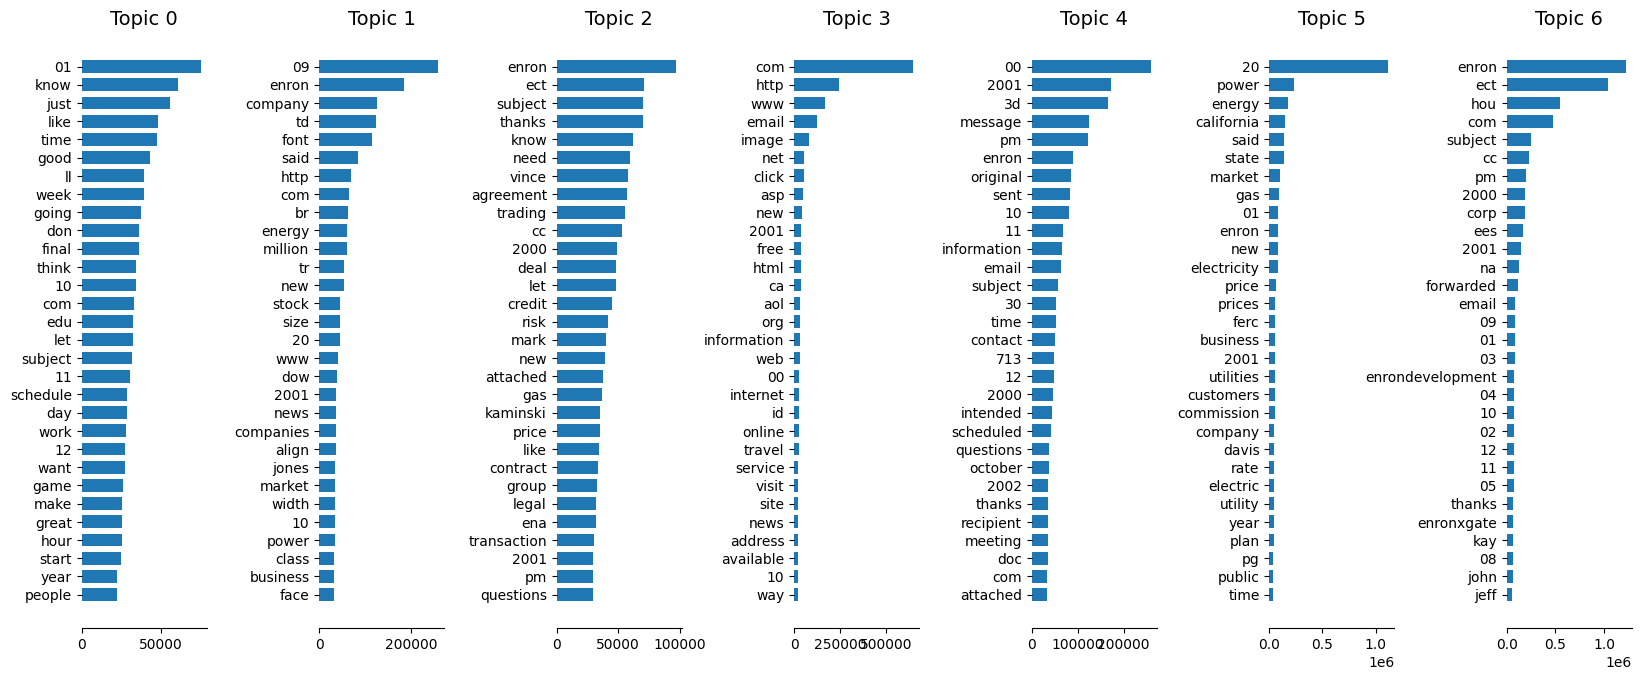

In [88]:
import matplotlib.pyplot as plt

n_top_words = 30

def plot_top_words(model, feature_names, title):
    fig, axes = plt.subplots(1, 7, figsize=(20, 7))
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx}", fontdict={"fontsize": 14})
        ax.tick_params(axis="both", which="major", labelsize=10)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    
plot_top_words(LDA, cv.get_feature_names_out(), f'Top {n_top_words} count')

In [89]:
# we decide the class name based on the main components:

myDict = {
    0: 'meeting', 
    1: 'energy', 
    2: 'finance', 
    3 :'neutral',
    4 :'neutral',
    5 :'energy',
    6 :'forwarded',
    
}

def add_class(df: pd.DataFrame):
    dtm = cv.transform(df['text'])
    topic_results = LDA.transform(dtm)
    
    df['topics'] = topic_results.argmax(axis=1)
    df['class'] = df['topics'].map(myDict)
    

# Load to BigQuery

In [90]:
# load to bigquery:

from google.cloud import bigquery

client = bigquery.Client.from_service_account_json('/Users/hugoramirez/Downloads/data-castle-bravo-40b8a58d089e.json')

def load_to_bigquery(df: pd.DataFrame):
    job_config = bigquery.LoadJobConfig(write_disposition="WRITE_APPEND")
    job = client.load_table_from_dataframe(df, 'data-castle-bravo.bootcamp_mlops.emails_classification', job_config=job_config)
    job.result()

In [91]:
BATCH_SIZE = 50_000
emails = []
df = None

for index, file in enumerate(get_all_files()):
    email_dict = {}
    email_content = read_email(file)
    email_dict = parser_email(email_content)
    emails.append(email_dict)

    if len(emails) % BATCH_SIZE == 0:
        df = pd.DataFrame.from_records(emails)
        df['Date'] = pd.to_datetime(df['Date'], utc=True)
        df = rename_columns(df)
        add_class(df)
        load_to_bigquery(df)

        print(f'batch until index {index + 1}')
        
        emails = []
        df = None

batch until index 50000
batch until index 100000
batch until index 150000
batch until index 200000
batch until index 250000
batch until index 300000
batch until index 350000
batch until index 400000
batch until index 450000
batch until index 500000


# Persist model

In [99]:
import pickle

pickle_cv = pickle.dump(cv, open('cv.pkl', 'wb'))
pickle_LDA = pickle.dump(LDA, open('LDA.pkl', 'wb'))


In [100]:
loaded_cv = pickle.load(open('cv.pkl', 'rb'))
loaded_LDA = pickle.load(open('cv.pkl', 'rb'))

In [104]:
test_str = '''Recap after interview yesterday with the candidate:
I found this person very easy to talk to and pleasant.  
I can imagine from a team perspective this person would be very easy for us to work with. He is enthusiastic, curious and had a good mind.
Technically:
I have lots of red flags. Very little experience with observability.  It was clear that this person did not even know what goes into observability.  
In addition, there was a tendency to talk about things that were not even related which I find concerning.  
I had to keep getting more and more specific like "tell me a time when you set up/used  monitoring, alerting  logging... or used   tracing so you knew..."  
I prefer working with contractors that are self-aware enough to know what they don't know.  I want to be clear that I did not think this person was trying to misrepresent themself.  
I believe his intent was good'''

df_test = pd.DataFrame({'text': [test_str]})
add_class(df_test)
df_test

,text,topics,class
0,Recap after interview yesterday with the candi...,0,meeting
